In [1]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.sparse import diags
from numpy.random import rand
from numpy import ones, zeros, outer
from functools import reduce
import numpy as np
from matplotlib.patches import Ellipse
import os

In [11]:
#constants
global DIM, NCOM, NSAMP, MEAN_SPREAD, epsilon
DIM=2 # Dimensions
NCOM=3 # Number of Components in Mixture Model
NSAMP=500 # Number of Samples per Component
#MEAN_SPREAD=8 # How far  out means spread
MEAN_SPREAD=DIM**NCOM
epsilon=1e-6
PLOTDIR='./plots/'
MAX_ITER=50

In [12]:
import numpy as np

def eigsorted(cov):
    """
    Calculate the eigenvalues and eigenvectors of the given covariance matrix.
    Sort the eigenvalues in descending order.

    Parameters:
    - cov (numpy.ndarray): The covariance matrix to compute eigenvalues and eigenvectors for.

    Returns:
    - tuple: A tuple containing:
        - vals (numpy.ndarray): The sorted eigenvalues in descending order.
        - vecs (numpy.ndarray): The corresponding eigenvectors.
    """
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    vals, vecs = np.linalg.eigh(cov)

    # Sort the eigenvalues in descending order and get the indices
    order = vals.argsort()[::-1]

    # Return the sorted eigenvalues and the corresponding eigenvectors
    return vals[order], vecs[:,order]


In [89]:
def draw_ellipse(mn, cov, ax):
    """
    Draw an ellipse based on the mean and covariance of a Gaussian component.

    Parameters:
    - mn (array): Mean of the Gaussian component.
    - cov (array): Covariance matrix of the Gaussian component.
    - ax (Axes): Matplotlib Axes object to draw the ellipse on.
    """
    nstd = 2
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # 2 std should be 95% of points inside ellipse
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(
        xy = mn,
        width = w,
        height = h,
        angle = theta,
        color = 'black',
        linewidth = 2,
        zorder = 3
    )
    ell.set_facecolor('none')
    ax.add_patch(ell)


In [90]:
def plot_all(mus, covs, labeled_points, name):
    """
    Plot ellipses representing Gaussian components and data points for each component.

    Parameters:
    - mus (list of arrays): List of means for each Gaussian component.
    - covs (list of arrays): List of covariance matrices for each Gaussian component.
    - labeled_points (dict): Dictionary of data points grouped by component.
    - name (str): Title or identifier for the plot.
    """
    # Use the tab10 colormap for distinct colors
    colormap = plt.get_cmap('jet')
    colors = [colormap(i) for i in np.linspace(0, 1, NCOM)]
    fig, ax = plt.subplots()

    # Draw data points and ellipses for each component
    for com in range(NCOM):
        # Scatter plot with edge colors and transparent face colors
        plt.scatter(
            x = labeled_points[com][:, 0],
            y = labeled_points[com][:, 1],
            c = [colors[com]],
            edgecolors = 'black',
            facecolors = 'none',
            s = 50,
            alpha = 0.3,
            zorder = 2  # higher zorder to keep these in the foreground
        )
        draw_ellipse(mus[com], covs[com], ax)

    # Add grid, labels, title and show the plot
    ax.grid(True, which='both', linestyle='--', linewidth=0.3, zorder=0)
    ax.set_title(name)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")

    # Uncomment the following line if you want to save the figure
    # plt.savefig(PLOTDIR + name + '.png')
    plt.show()
    plt.close(fig)


In [91]:
def generate_data(numcom, samppercom):
    """
    Generate data based on random mean and random positive semidefinite covariance matrices.

    Parameters:
    - numcom (int): Number of components.
    - samppercom (int): Number of samples to be drawn per component.

    Returns:
    - tuple: A tuple containing:
        - unlabeled_points (list): A list of unlabeled points from all components.
        - labeled_points (dict): A dictionary with keys as component indices and values as the points belonging to that component.
    """
    # Dictionary to hold the labeled points for each component
    labeled_points = dict()

    # List to hold all the points without labels
    unlabeled_points = []

    # Generate random means and covariance matrices, and sample points for each component
    for com in range(numcom):
        mn = (MEAN_SPREAD * rand(DIM)) - (MEAN_SPREAD/2)
        cv = rand(DIM, DIM) - 0.5
        cv = (cv + cv.transpose()) + diags(ones(DIM))

        # Sample points from the multivariate normal distribution with generated mean and covariance
        labeled_points[com] = multivariate_normal.rvs(mean=mn, cov=cv, size=samppercom)

    # Combine all labeled points into the unlabeled points list
    for com in range(numcom):
        unlabeled_points.extend(labeled_points[com].tolist())

    return unlabeled_points, labeled_points


**E-step:** Evaluate responsibilities $r_{nk}$ for every data point $x_n$     using the current parameters $\mu_k,\Sigma_k,$ and $\pi_k$:
    \begin{align}
        r_{nk}=\frac{\pi_k\mathcal{N}(x_n~|~\mu_k,\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal{N}(x_n~|~\mu_j\Sigma_j)}
    \end{align}


In [92]:
def map_function(data_point):
    """
    Map function for the E-step of the EM algorithm. Computes responsibilities for the given data point for each component.

    Parameters:
    - data_point (list): A single data point.

    Returns:
    - None: The function does not return any value but emits mapper key-value pairs.
            For the sake of the provided code, the emitting mechanism is abstracted.
    """
    # Calculate the denominator for the responsibilities
    denom = sum([pi_k[k] * multivariate_normal(mean=mus[k], cov=covs[k]).pdf(data_point) for k in range(NCOM)])

    # Emit responsibilities for current data point and each of the NCOM components
    for i in range(NCOM):
        emit_mapper_kvp(i, (data_point, (pi_k[i] * multivariate_normal(mean=mus[i], cov=covs[i]).pdf(data_point) / denom)))


**M-step:** Re-estimate parameters with these updated responsibilities from the $E$ step using
    \begin{align}
        \mu_k=\frac{1}{N_k}\sum_{n=1}^N r_{nk}x_n, \quad
        \Sigma_k=\frac{1}{N_k}\sum_{n=1}^N r_{nk}(x_n-\mu_k)(x_n-\mu_k)^T,\quad
        \pi_k=\frac{N_k}{N}
    \end{align}
where $N_k$ is the sum of all entries in the $k^{th}$ column of the $N\times K$ responsibility matrix.

In [93]:
def reduce_function(cluster_index, map_value_iterator):
    """
    Reduce function for the M-step of the EM algorithm. Computes the mean, covariance, and sum of responsibilities for a given cluster index.

    Parameters:
    - cluster_index (int): The index of the cluster (component) being considered.
    - map_value_iterator (iterator): An iterator over the values (data points and responsibilities) associated with the given cluster index.

    Returns:
    - tuple: A tuple containing:
        - cluster_mean (numpy.ndarray): The mean for the cluster.
        - cluster_covariance (numpy.ndarray): The covariance matrix for the cluster.
        - Respons_column_sum (float): The sum of responsibilities for the cluster.
    """
    cluster_mean = 0
    Respons_column_sum = 0
    cluster_covariance = np.zeros(shape=(DIM, DIM))

    # Iterate over the values and compute the cluster mean, covariance, and sum of responsibilities
    for map_value in map_value_iterator:
        cluster_mean += np.array(map_value[0]) * np.array(map_value[1])  # data_point * 'responsibility' for this cluster index
        cluster_covariance += np.array(map_value[1]) * (np.outer(np.array(map_value[0]), np.array(map_value[0])))
        Respons_column_sum += map_value[1]

    return (cluster_mean, cluster_covariance, Respons_column_sum)


In [94]:
def emit_mapper_kvp(cluster_index, map_value):
    """
    Emulates the shuffle step of the MapReduce paradigm by collecting values for a given key.

    Parameters:
    - cluster_index (int): The index of the cluster (component) being considered.
    - map_value (tuple): The value to be appended for the given key.

    Returns:
    - None: This function modifies the global `reducer_values` dictionary in-place.
    """
    global reducer_values
    reducer_values[cluster_index].append(map_value)


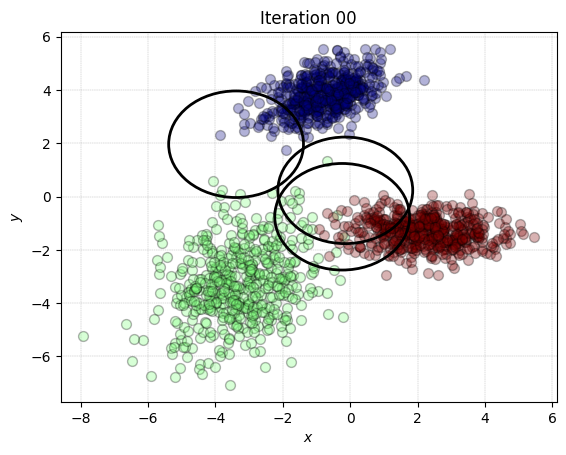

μ change = 5.244904996751978


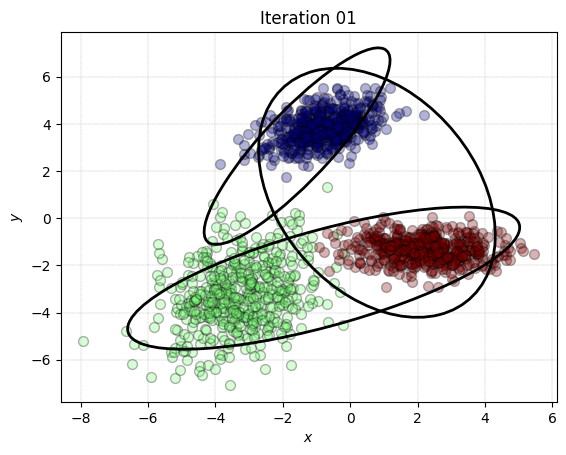

μ change = 0.6949349985490185


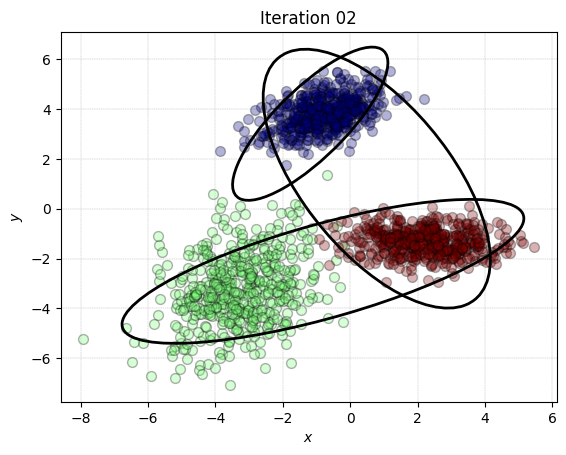

μ change = 0.6192760957433229


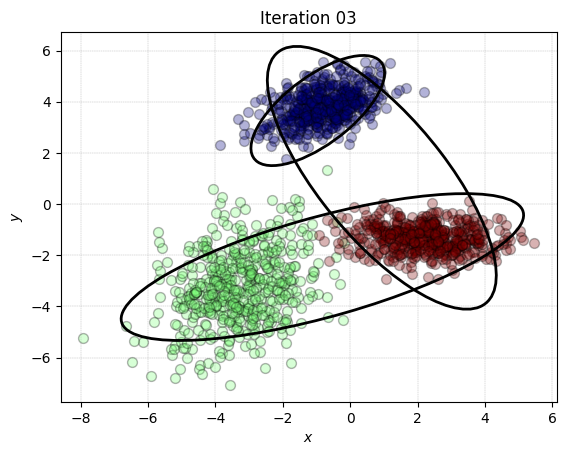

μ change = 0.8470805834584472


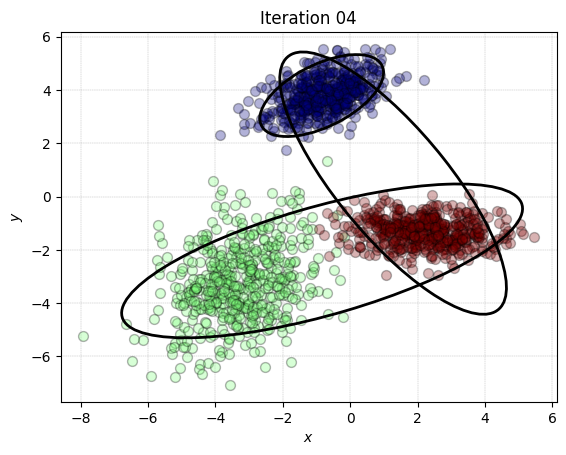

μ change = 0.8731106061703987


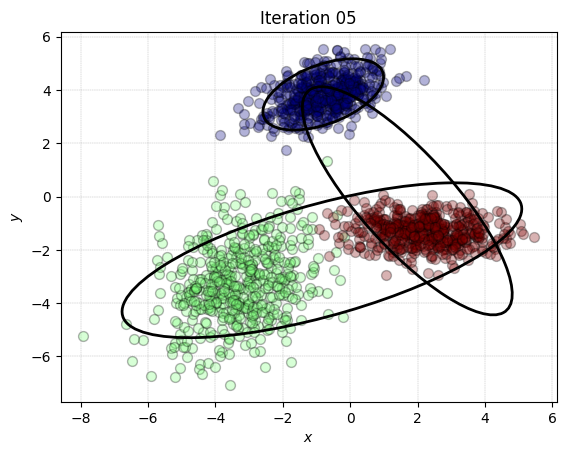

μ change = 0.7486153220889085


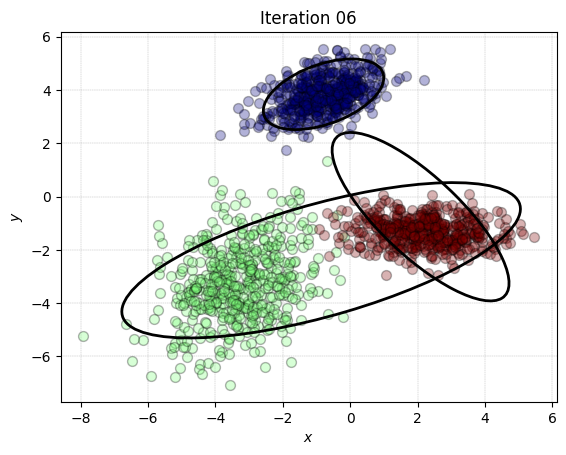

μ change = 0.6341684198775492


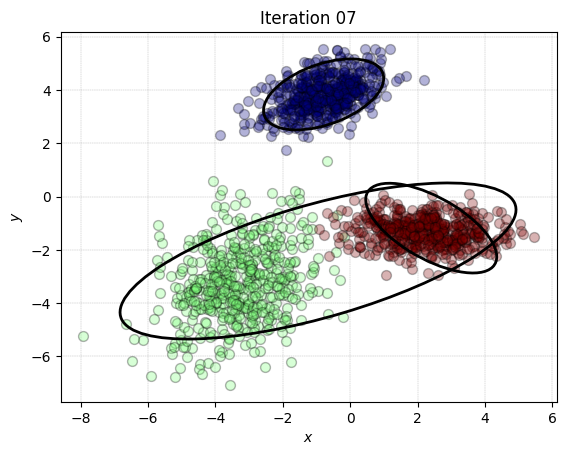

μ change = 0.45041153301483206


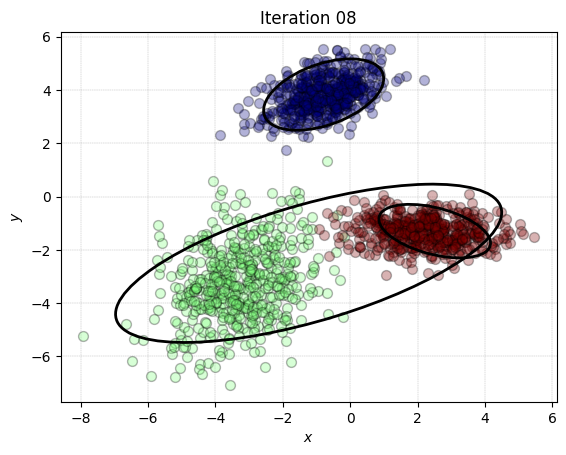

μ change = 0.4335643155054125


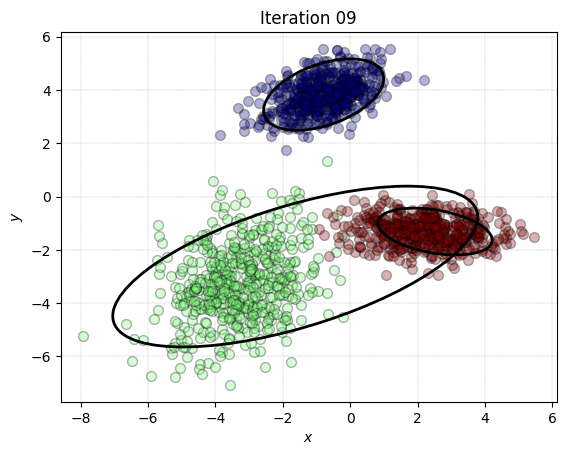

μ change = 0.39754117358917307


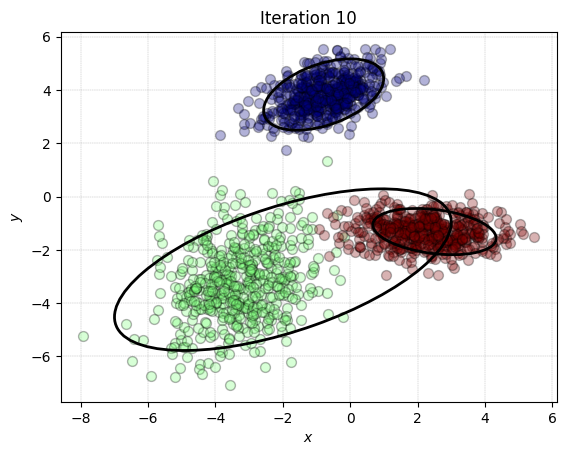

μ change = 0.3813439977631982


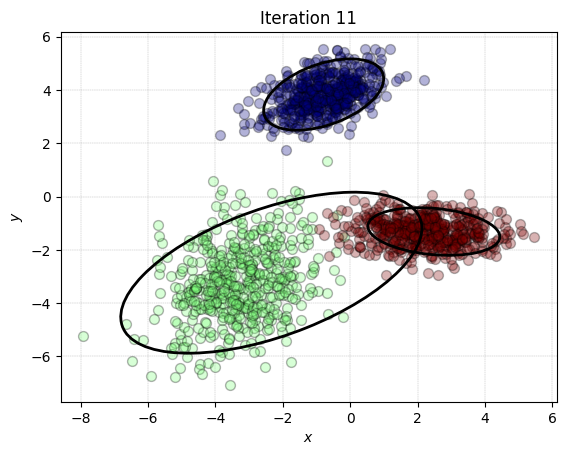

μ change = 0.3715228905478883


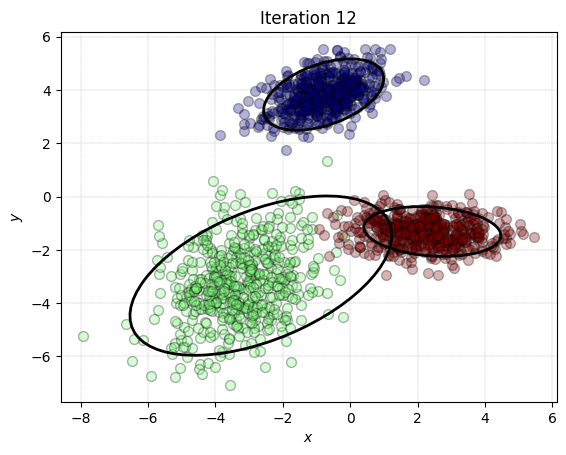

μ change = 0.3387809193382888


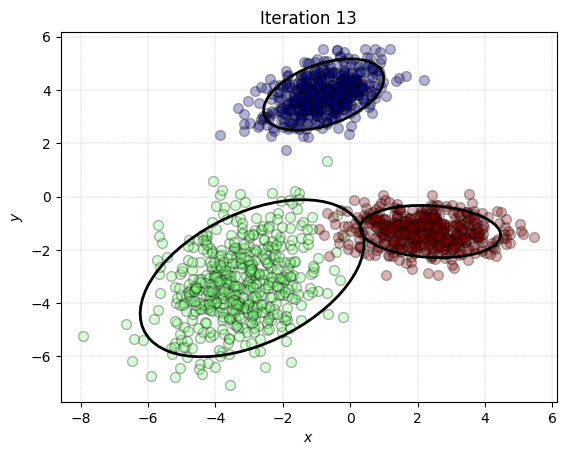

μ change = 0.2719223069680175


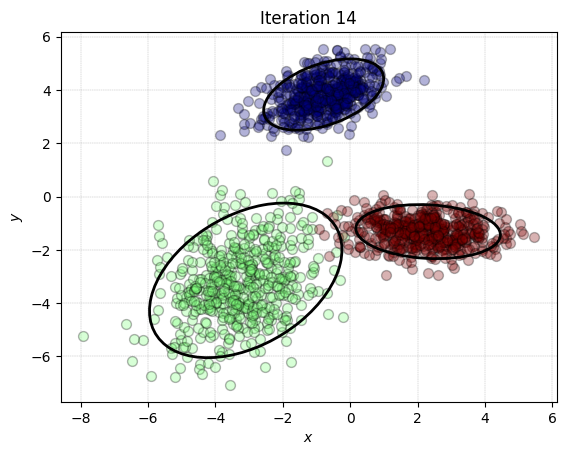

μ change = 0.1771639949001823


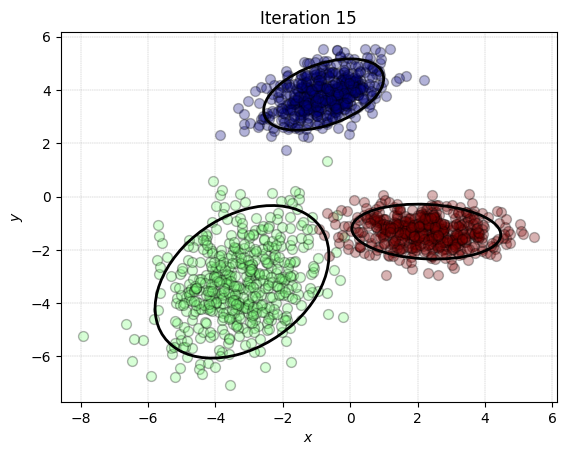

μ change = 0.09275384896016782


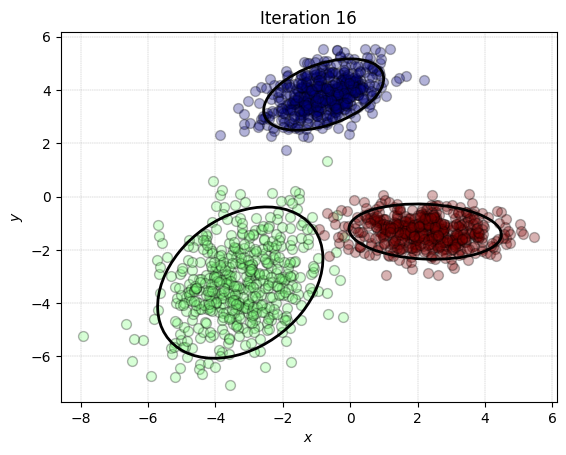

μ change = 0.04094907228292653


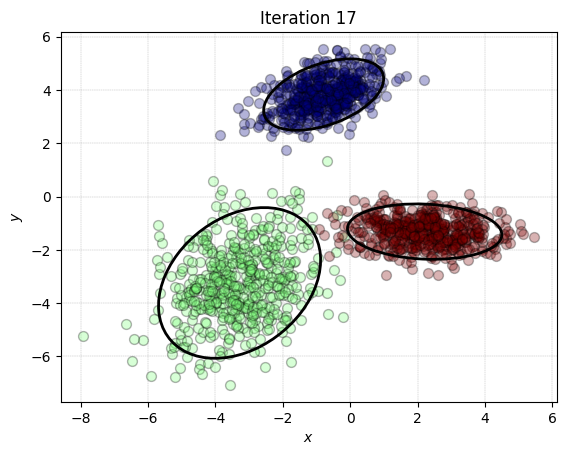

μ change = 0.016721076468208522


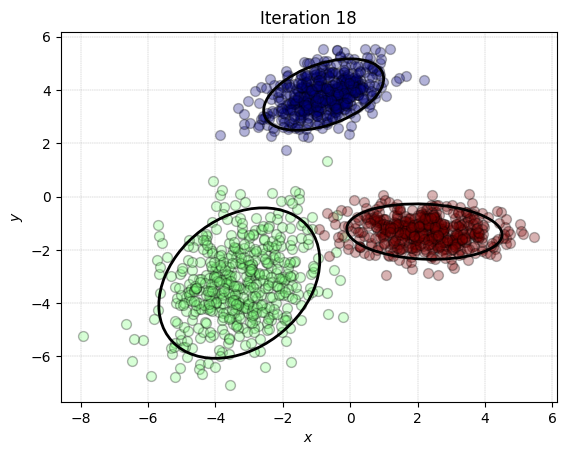

μ change = 0.006658755106602052


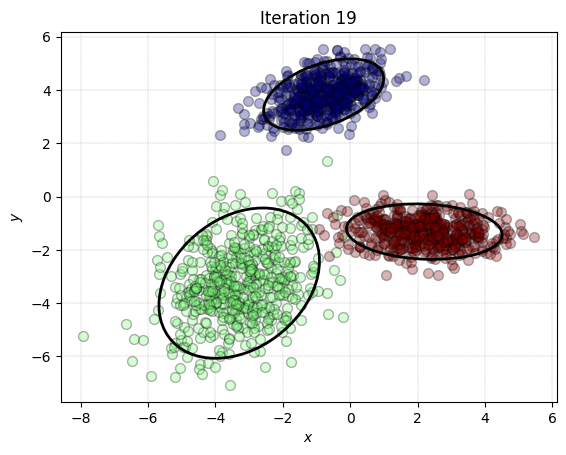

μ change = 0.002631685974635521


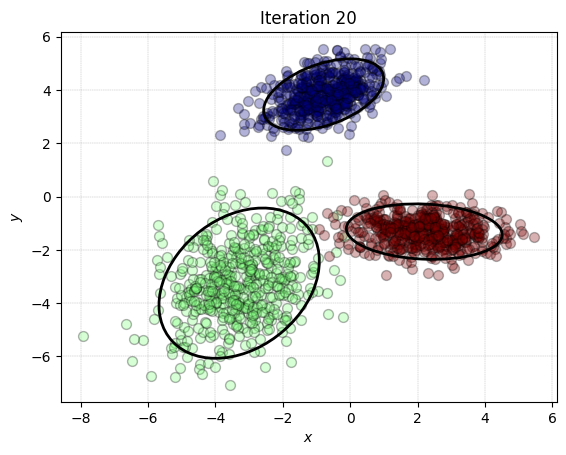

μ change = 0.00103751206562819


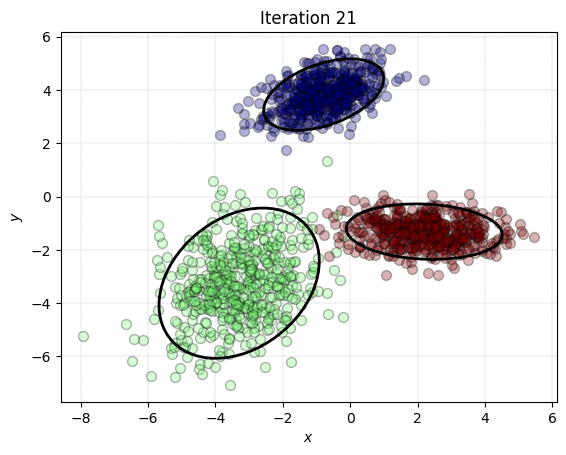

μ change = 0.00040865606930329474


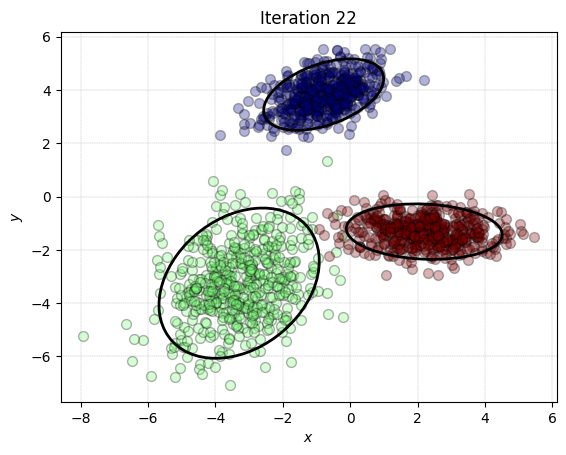

Breaking because:
μ change = 0.00040865606930329474


In [107]:
# Generate the data
unlabeled_points, labeled_points = generate_data(NCOM, NSAMP)

# Initialization for EM algorithm
global mus, covs, pi_k, N_k
mus, covs, pi_k, N_k = [], [], [], []
for i in range(NCOM):
    mus.append((MEAN_SPREAD * rand(DIM)) - (MEAN_SPREAD / 2))
    covs.append(np.eye(DIM))
    pi_k.append(1 / NCOM)
    N_k.append(1 / (NCOM * NSAMP))

# Plot with initial values
plot_all(mus, covs, labeled_points, "Iteration %02i" % 0)

# Emulation of the MapReduce approach for the EM algorithm
for iteration in range(MAX_ITER):
    #print(f'iteration: {iteration + 1}')

    # Reset reducer values for a fresh iteration
    reducer_values = dict(map(lambda x: (x, []), range(NCOM)))
    iter_checker = mus.copy()

    # "Map" step (E-step)
    for data_point in unlabeled_points:
        map_function(data_point)

    # "Reduce" step (M-step)
    for i in range(NCOM):
        reduce_iterator = iter(reducer_values[i])
        mu, cov, N_k[i] = reduce_function(i, reduce_iterator)
        pi_k[i] = (N_k[i] / (NSAMP * NCOM))
        mus[i] = mu / N_k[i]
        cov = cov / N_k[i]
        covs[i] = cov - np.outer(np.array(mus[i]), np.array(mus[i]))
        min_eig = np.min(np.real(np.linalg.eigvals(covs[i])))
        if min_eig < 0:
            covs[i] = epsilon * np.eye(DIM) + cov

    # Check the convergence of the EM algorithm
    check = np.sum([np.linalg.norm(iter_checker[i] - mus[i]) for i in range(NCOM)])
    print(f'\u03BC change = {check}')

    # Plot the current iteration
    plot_all(mus, covs, labeled_points, f"Iteration %02i" % (iteration + 1))

    # Break if convergence criteria is met
    if iteration > 2 and check <= .001:
        print('Breaking because:')
        print(f'\u03BC change = {check}')
        break